In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.chdir('..')

import pickle
import re
from pathlib import Path
import json

import numpy as np
import pandas as pd

from tqdm import tqdm

pd.set_option('display.max_rows', 200)

import matplotlib as mpl
mpl.rcParams['font.size'] = 14           # Base font size
mpl.rcParams['axes.labelsize'] = 14      # Axis label font size
mpl.rcParams['axes.titlesize'] = 14      # Title font size
mpl.rcParams['xtick.labelsize'] = 12     # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 12     # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 13     # Legend font size

## load evaluation results for runs with prefixes (left context)

In [2]:
model_names = ['EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
               'meta-llama/Llama-3.2-1B', 'meta-llama/Meta-Llama-3.1-8B']

prefix_lengths = [64, 128, 512, 1024]
max_lengths = [64, 96, 128, 256, 512, 1024, 1568, 2048]
N_mem_tokens = 1

data = []

for model_name in model_names:
    for max_length in max_lengths:
        mem_results_path = Path(f'./runs/{model_name}/mem_{N_mem_tokens}_len_{max_length}.pkl')
        prefix_results_path = mem_results_path.parent / 'with_prefix' / f'mem_{N_mem_tokens}_len_{max_length}.json'
        
        if not prefix_results_path.exists():
            continue

        results = json.load(prefix_results_path.open('r'))
        for k in results:
            for res in results[k]:
                res['model_name'] = model_name
                data += [res]

In [3]:
df = pd.DataFrame(data)
df['original_CE'] = df['original_loss'] * df['max_length']
df['CE'] =  df['loss'] * df['max_length']
df['best_CE'] = df['best_loss'] * df['max_length']

df = df.drop(['n_mem_tokens', 'sample_idx'], axis=1)
df = df[((df['model_name']=='meta-llama/Meta-Llama-3.1-8B') & (df['max_length']==1568)) |
        ((df['model_name']=='meta-llama/Llama-3.2-1B') & (df['max_length']==512)) |
        ((df['model_name']=='EleutherAI/pythia-1.4b') & (df['max_length']==128)) |
        ((df['model_name']=='EleutherAI/pythia-410m') & (df['max_length']==64))
]
df[df['max_length'].isin([1568, 512, 128, 64])].groupby(['model_name', 'max_length', 'prefix_length']).agg('mean')

loss  accuracy  \
model_name                   max_length prefix_length                       
EleutherAI/pythia-1.4b       128        64             2.951366  0.399213   
                                        128            2.880573  0.409764   
                                        512            2.748603  0.432126   
                                        1024           2.728028  0.432913   
EleutherAI/pythia-410m       64         64             3.226236  0.368889   
                                        128            3.151847  0.377143   
                                        512            3.004091  0.395556   
                                        1024           2.974295  0.399365   
meta-llama/Llama-3.2-1B      512        64             2.805836  0.421843   
                                        128            2.780589  0.424078   
                                        512            2.705536  0.434510   
                                        1024           2.668424  0.439059   
meta-llama/Meta-Llama-3.1-8B 1568       64             2.295685  0.492069   
                                        128            2.281737  0.494572   
                                        512            2.244327  0.499540   
                                        1024           2.221965  0.502988   

                                                       original_loss  \
model_name                   max_length prefix_length                  
EleutherAI/pythia-1.4b       128        64                  3.212652   
                                        128                 3.212652   
                                        512                 3.212652   
                                        1024                3.212652   
EleutherAI/pythia-410m       64         64                  3.618356   
                                        128                 3.618356   
                                        512                 3.618356   
                                        1024                3.618356   
meta-llama/Llama-3.2-1B      512        64                  2.912045   
                                        128                 2.912045   
                                        512                 2.912045   
                                        1024                2.912045   
meta-llama/Meta-Llama-3.1-8B 1568       64                  2.337136   
                                        128                 2.337136   
                                        512                 2.337136   
                                        1024                2.337136   

                                                       original_accuracy  \
model_name                   max_length prefix_length                      
EleutherAI/pythia-1.4b       128        64                      0.372283   
                                        128                     0.372283   
                                        512                     0.372283   
                                        1024                    0.372283   
EleutherAI/pythia-410m       64         64                      0.321270   
                                        128                     0.321270   
                                        512                     0.321270   
                                        1024                    0.321270   
meta-llama/Llama-3.2-1B      512        64                      0.411429   
                                        128                     0.411429   
                                        512                     0.411429   
                                        1024                    0.411429   
meta-llama/Meta-Llama-3.1-8B 1568       64                      0.488271   
                                        128                     0.488271   
                                        512                     0.488271   
                                        1024                    0.488271   

      

## PG19 vs fanfics vs random

In [4]:
# model_names = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m',  'EleutherAI/pythia-1.4b',
            #    'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']

model_names = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
               'EleutherAI/pythia-2.8b',
               'facebook/opt-1.3b', 'allenai/OLMo-1B-0724-hf',
               'princeton-nlp/Sheared-LLaMA-1.3B',
               'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B',
                ]


N_mem_tokens = 1

# load PG-19 & random texts & fanfics
data = []
for model_name in tqdm(model_names):
    for runs_path in ['runs', 'runs_fanfics']:
        load_path = Path(f'./{runs_path}/{model_name}/')

        if runs_path == 'runs':
            source = 'pg19'
        elif runs_path == 'runs_fanfics':
            source = 'fanfics'

        for file_path in load_path.glob(f'mem_{N_mem_tokens}_len_*.pkl'):
            if file_path.is_file():
                # Extract max_length from the file name using regex
                match = re.search(f'mem_{N_mem_tokens}_len_(\d+)(_rnd_vocab_100k)?\.pkl', file_path.name)
                if match:
                    max_length = int(match.group(1))
                else:
                    continue
                
                try:
                    with open(file_path, 'rb') as f:
                        d = pickle.load(f)
                except Exception as e:
                    continue

            try:
                d = pickle.load(open(file_path, 'rb'))
            except:
                continue
            for el in d:
                data += [{
                    'model_name': model_name,
                    'max_length': el['max_length'],
                    'n_mem_tokens': el['n_mem_tokens'],
                    'original_loss': el['original_loss'],
                    'original_accuracy': el['original_accuracy'],
                    'best_loss': np.min(el['losses'][:5000]),#el['best_loss'],
                    'best_accuracy': np.max(el['accuracies'][:5000]),#el['best_accuracy'],#np.max(el['accuracies'][:5000]), #
                    'source': source if not el['args'].get('shuffled', False) else 'random',
                }]

    data_df = pd.DataFrame(data)

100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


In [5]:
data_df['original_CE'] = data_df['original_loss'] * data_df['max_length']
data_df['best_CE'] = data_df['best_loss'] * data_df['max_length']
data_df['diff_CE'] = data_df['original_CE'] - data_df['best_CE']

# similar, but let's count number of correctly predicted tokens
data_df['best_n_correct_tokens'] = data_df['best_accuracy'] * data_df['max_length']
data_df['original_n_correct_tokens'] = data_df['original_accuracy'] * data_df['max_length']
data_df['diff_n_correct_tokens'] = data_df['best_n_correct_tokens'] - data_df['original_n_correct_tokens']

## get max text compression length (pg19, fanfics, random)

In [6]:
# find max length bin (or just length) with avg token accuracy >= thr
thr = 0.99
for source in ['pg19', 'fanfics', 'random']:
    texts_df = data_df[data_df['source'] == source]
    texts_df = texts_df.drop(['source'], axis=1)
    agg_df = texts_df.groupby(['model_name', 'max_length']).agg('mean').reset_index()
    max_lengths_df = agg_df[agg_df['best_accuracy'] >= thr].groupby(['model_name'], as_index=False).agg({'max_length': 'max'}).sort_values('max_length')
    print(source)
    print(max_lengths_df)
    print('------------------')

pg19
                         model_name  max_length
1            EleutherAI/pythia-160m          80
3            EleutherAI/pythia-410m          96
2            EleutherAI/pythia-2.8b         128
5                 facebook/opt-1.3b         128
0            EleutherAI/pythia-1.4b         160
4           allenai/OLMo-1B-0724-hf         384
6           meta-llama/Llama-3.2-1B         512
9  princeton-nlp/Sheared-LLaMA-1.3B         512
7           meta-llama/Llama-3.2-3B        1024
8      meta-llama/Meta-Llama-3.1-8B        1568
------------------
fanfics
                     model_name  max_length
1        EleutherAI/pythia-160m          80
2        EleutherAI/pythia-410m          96
0        EleutherAI/pythia-1.4b         192
3       meta-llama/Llama-3.2-1B         512
4       meta-llama/Llama-3.2-3B        1024
5  meta-llama/Meta-Llama-3.1-8B        1568
------------------
random
                         model_name  max_length
1            EleutherAI/pythia-160m          65
3         

In [7]:
from scipy.optimize import curve_fit

thr = 0.99
src = 'random'
texts_df = data_df[data_df['source'] == src]
texts_df = texts_df.drop(['source'], axis=1)
texts_df

def approx_fn(x, a, b):
    return a * x + b

for model_name in sorted(texts_df['model_name'].unique()):
    model_df = texts_df[texts_df['model_name'] == model_name]
    # params, _ = curve_fit(approx_fn, texts_df, y_data)

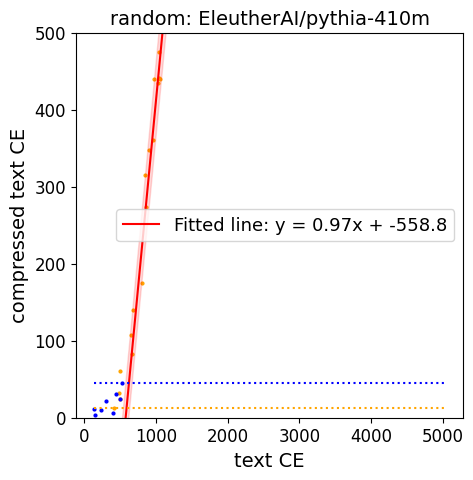

In [8]:
import matplotlib.pyplot as plt

def approx_fn(x, a, b):
    return a * x + b

thr=0.99

model_name = model_names[1]

model_df = texts_df[texts_df['model_name'] == model_name]

below_thr_df = model_df[model_df['best_accuracy'] < thr]
above_thr_df = model_df[model_df['best_accuracy'] >= thr]
x_data = below_thr_df['original_CE']
y_data = below_thr_df['best_CE']

params, covar = curve_fit(approx_fn, x_data, y_data)
a, b = params
sigma_ab = np.sqrt(np.diagonal(covar))

x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = approx_fn(x_fit, *params)

bound_upper = approx_fn(x_fit, *(params + 3 * sigma_ab))
bound_lower = approx_fn(x_fit, *(params - 3 * sigma_ab))

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot()

ax1.scatter(below_thr_df['original_CE'], below_thr_df['best_CE'], s=4.0, color='orange')
ax1.scatter(above_thr_df['original_CE'], above_thr_df['best_CE'], s=4.0, color='blue')

formula_label = f'Fitted line: y = {a:.2f}x + {b:.1f}'
ax1.plot(x_fit, y_fit, color='red', label=formula_label)
ax1.fill_between(x_fit, bound_lower, bound_upper, color='red', alpha=0.15)

xmin, xmax = model_df['original_CE'].min(), model_df['original_CE'].max()

# points that has CE overlap, but separated by accuracy
ax1.hlines(below_thr_df['best_CE'].min(), xmin, xmax, color='orange', linestyles='dotted')
ax1.hlines(above_thr_df['best_CE'].max(), xmin, xmax, color='blue', linestyles='dotted')
# take mean, remove outliers
model_df[(model_df['best_CE'] <= above_thr_df['best_CE'].max()) &
         (model_df['best_CE'] >= below_thr_df['best_CE'].min())]


ax1.legend()
ax1.set_title(f'{src}: {model_name}')
ax1.set_xlabel('text CE')
ax1.set_ylabel('compressed text CE')
ax1.set_ylim(0.0, 500)

fig.show()

In [10]:
thr = 0.99
below_thr_df = texts_df[texts_df['best_accuracy'] < thr]
above_thr_df = texts_df[texts_df['best_accuracy'] >= thr]
# texts_df[texts_df['best_accuracy'] >= thr].groupby(['model_name']).agg(('mean', 'std'))

In [11]:
df = below_thr_df.groupby(['model_name', 'max_length']).agg(('mean', 'std'))
df = df.drop(['n_mem_tokens', 'original_loss', 'best_loss'], axis=1).reset_index()
df.head()

model_name max_length original_accuracy     best_accuracy      \
                                                  mean std          mean std   
0  EleutherAI/pythia-1.4b        160          0.150943 NaN      0.987421 NaN   
1  EleutherAI/pythia-1.4b        161          0.106250 NaN      0.925000 NaN   
2  EleutherAI/pythia-1.4b        165          0.103659 NaN      0.963415 NaN   
3  EleutherAI/pythia-1.4b        196          0.097436 NaN      0.728205 NaN   
4  EleutherAI/pythia-1.4b        205          0.078431 NaN      0.715686 NaN   

   original_CE         best_CE         diff_CE     best_n_correct_tokens      \
          mean std        mean std        mean std                  mean std   
0  1001.499481 NaN   87.814875 NaN  913.684607 NaN            157.987413 NaN   
1  1086.238169 NaN  177.953829 NaN  908.284340 NaN            148.925002 NaN   
2  1081.148379 NaN  110.061294 NaN  971.087085 NaN            158.963411 NaN   
3  1305.060617 NaN  366.299575 NaN  938.761042 NaN            142.728208 NaN   
4  1365.040340 NaN  467.896132 NaN  897.144208 NaN            146.715696 NaN   

  original_n_correct_tokens     diff_n_correct_tokens      
                       mean std                  mean std  
0                 24.150944 NaN            133.836470 NaN  
1                 17.106250 NaN            131.818751 NaN  
2                 17.103658 NaN            141.859752 NaN  
3                 19.097436 NaN            123.630772 NaN  
4                 16.078432 NaN            130.637264 NaN

In [64]:
', '.join([str(el) for el in sorted(data_df[data_df['source'] == 'pg19']['max_length'].unique())])

'8, 16, 32, 64, 80, 96, 128, 160, 192, 256, 384, 512, 768, 1024, 1280, 1568, 2048, 2560, 3072'

In [49]:
pd.set_option('display.float_format', '{:.1f}'.format)  # Adjust precision as needed

models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
          'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']

thr = 0.99
df = data_df[data_df['best_accuracy'] <= thr].groupby(['source', 'model_name']).agg(('mean', 'std'))
# df = df.drop(['n_mem_tokens', 'original_loss', 'original_accuracy', 'best_accuracy', 'best_loss', 'max_length'], axis=1).reset_index().sort_values(['source', ('diff_CE', 'mean')])
df = df.drop(['n_mem_tokens', 'original_loss', 'original_accuracy',
              'best_accuracy', 'best_loss', 'max_length',
              'original_CE', 'best_CE', 'best_n_correct_tokens', 'original_n_correct_tokens',
              ], axis=1).reset_index().sort_values(['source', ('diff_CE', 'mean')])
# df = df[df['model_name'].isin(models)]

In [50]:
df

source                        model_name diff_CE        \
                                                 mean   std   
1   fanfics            EleutherAI/pythia-160m   378.1  45.9   
2   fanfics            EleutherAI/pythia-410m   429.8  46.2   
0   fanfics            EleutherAI/pythia-1.4b   776.9 132.5   
3   fanfics           meta-llama/Llama-3.2-1B  2213.8 365.8   
4   fanfics           meta-llama/Llama-3.2-3B  3354.5 344.9   
5   fanfics      meta-llama/Meta-Llama-3.1-8B  4768.9 622.6   
7      pg19            EleutherAI/pythia-160m   396.4  46.0   
9      pg19            EleutherAI/pythia-410m   431.4  51.6   
11     pg19                 facebook/opt-1.3b   712.8 143.3   
8      pg19            EleutherAI/pythia-2.8b   740.3 234.9   
6      pg19            EleutherAI/pythia-1.4b   792.8 143.4   
15     pg19  princeton-nlp/Sheared-LLaMA-1.3B  1835.1 162.9   
10     pg19           allenai/OLMo-1B-0724-hf  1901.0 254.5   
12     pg19           meta-llama/Llama-3.2-1B  2119.9 364.8   
13     pg19           meta-llama/Llama-3.2-3B  3292.2 320.0   
14     pg19      meta-llama/Meta-Llama-3.1-8B  4865.7 546.6   
17   random            EleutherAI/pythia-160m   500.8  38.9   
19   random            EleutherAI/pythia-410m   630.4  65.2   
18   random            EleutherAI/pythia-2.8b  1023.7 218.8   
21   random                 facebook/opt-1.3b  1066.4 181.7   
16   random            EleutherAI/pythia-1.4b  1108.2 136.2   
20   random           allenai/OLMo-1B-0724-hf  1852.2 395.0   
25   random  princeton-nlp/Sheared-LLaMA-1.3B  1893.0 210.0   
22   random           meta-llama/Llama-3.2-1B  2265.2 498.7   
23   random           meta-llama/Llama-3.2-3B  3382.6 585.2   
24   random      meta-llama/Meta-Llama-3.1-8B  4541.2 758.6   

   diff_n_correct_tokens        
                    mean   std  
1                   70.9  10.5  
2                   81.2  11.6  
0                  152.9  28.0  
3                  449.6  83.7  
4                  734.1  85.0  
5                 1071.8 168.6  
7                   70.9  11.0  
9                   81.3  12.0  
11                 132.2  23.8  
8                  150.1  50.7  
6                  158.0  29.1  
15                 383.6  38.4  
10                 406.3  61.7  
12                 426.2  79.2  
13                 720.3  80.2  
14                1094.1 127.6  
17                  61.3   6.6  
19                  76.9   8.7  
18                 134.3  25.5  
21                 129.3  16.5  
16                 144.4  17.5  
20                 257.3  55.0  
25                 315.1  35.1  
22                 294.9  64.8  
23                 456.9  72.1  
24                 623.2  97.3

In [13]:
df[(df['source']=='pg19')].T

7   \
source                                            pg19   
model_name                      EleutherAI/pythia-160m   
original_CE               mean             1004.640662   
                          std               505.645552   
best_CE                   mean              608.217803   
                          std                493.56312   
diff_CE                   mean              396.422859   
                          std                45.997844   
best_n_correct_tokens     mean              162.543898   
                          std                52.794984   
original_n_correct_tokens mean               91.651611   
                          std                51.085034   
diff_n_correct_tokens     mean               70.892288   
                          std                10.975483   

                                                    9                  11  \
source                                            pg19               pg19   
model_name                      EleutherAI/pythia-410m  facebook/opt-1.3b   
original_CE               mean             2100.330966        2145.629029   
                          std              1485.453405        1399.050877   
best_CE                   mean              1668.95226         1432.78639   
                          std              1460.113914        1280.698802   
diff_CE                   mean              431.378706         712.842639   
                          std                51.586735         143.268467   
best_n_correct_tokens     mean              341.364819         420.494097   
                          std               196.786918         213.017803   
original_n_correct_tokens mean                 260.089         288.295312   
                          std               195.612718         200.022574   
diff_n_correct_tokens     mean               81.275819         132.198785   
                          std                11.955303          23.799299   

                                                    8   \
source                                            pg19   
model_name                      EleutherAI/pythia-2.8b   
original_CE               mean             2051.344233   
                          std              1006.779643   
best_CE                   mean             1311.055157   
                          std               911.168386   
diff_CE                   mean              740.289076   
                          std               234.884707   
best_n_correct_tokens     mean              473.680285   
                          std               193.552265   
original_n_correct_tokens mean              323.597774   
                          std               168.693412   
diff_n_correct_tokens     mean              150.082511   
                          std                50.713665   

                                                    6   \
source                                            pg19   
model_name                      EleutherAI/pythia-1.4b   
original_CE               mean             2315.668834   
                          std               1276.47716   
best_CE                   mean              1522.82137   
                          std              1187.175788   
diff_CE                   mean              792.847463   
                          std               143.351024   
best_n_correct_tokens     mean              495.724175   
                          std               209.227592   
original_n_correct_tokens mean              337.680224   
                          std                198.88438   
diff_n_correct_tokens     mean              158.043951   
                          std                29.053571   

                                                              15  \
source                                                      pg19   
model_name                      princeton-nlp/Sheared-LLaMA-1.3B   
original_CE               mean                       3498.000601   
           

In [14]:
df[(df['source']=='random')].T

17  \
source                                          random   
model_name                      EleutherAI/pythia-160m   
original_CE               mean             1086.584524   
                          std               380.873308   
best_CE                   mean              585.816646   
                          std               369.136856   
diff_CE                   mean              500.767878   
                          std                38.866135   
best_n_correct_tokens     mean               72.388534   
                          std                 8.197622   
original_n_correct_tokens mean               11.084547   
                          std                 5.700546   
diff_n_correct_tokens     mean               61.303987   
                          std                 6.587612   

                                                    19  \
source                                          random   
model_name                      EleutherAI/pythia-410m   
original_CE               mean             2591.834943   
                          std               1377.39236   
best_CE                   mean             1961.385645   
                          std              1340.333586   
diff_CE                   mean              630.449299   
                          std                65.198635   
best_n_correct_tokens     mean              118.171142   
                          std                26.809257   
original_n_correct_tokens mean               41.286339   
                          std                25.358899   
diff_n_correct_tokens     mean               76.884803   
                          std                 8.712983   

                                                    18                 21  \
source                                          random             random   
model_name                      EleutherAI/pythia-2.8b  facebook/opt-1.3b   
original_CE               mean             4219.213146        3913.654525   
                          std              2081.901415        2191.507007   
best_CE                   mean              3195.51656        2847.210273   
                          std              1975.435911        2028.829496   
diff_CE                   mean             1023.696586        1066.444253   
                          std               218.844218         181.663778   
best_n_correct_tokens     mean              224.452153         207.971857   
                          std                58.818697          59.701327   
original_n_correct_tokens mean               90.132176          78.680798   
                          std                45.600468          47.173815   
diff_n_correct_tokens     mean              134.319977         129.291059   
                          std                25.493728          16.451887   

                                                    16  \
source                                          random   
model_name                      EleutherAI/pythia-1.4b   
original_CE               mean             3989.647082   
                          std              1915.127417   
best_CE                   mean             2881.403823   
                          std              1860.590574   
diff_CE                   mean              1108.24326   
                          std               136.216701   
best_n_correct_tokens     mean               223.59512   
                          std                45.886225   
original_n_correct_tokens mean               79.212752   
                          std                41.048813   
diff_n_correct_tokens     mean              144.382367   
                          std                17.546351   

                                                     20  \
source                                           random   
model_name                      allenai/OLMo-1B-0724-hf   
original_CE               mean              4480.292528   
                          std               201

/tmp/ipykernel_1540434/1191877141.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))
/tmp/ipykernel_1540434/1191877141.py:56: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(polynomial, x_data, y_data)
/tmp/ipykernel_1540434/1191877141.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 1, 0.95], w_pad=.00, h_pad=0.5)  # Adjust layout to accommodate legends and labels properly


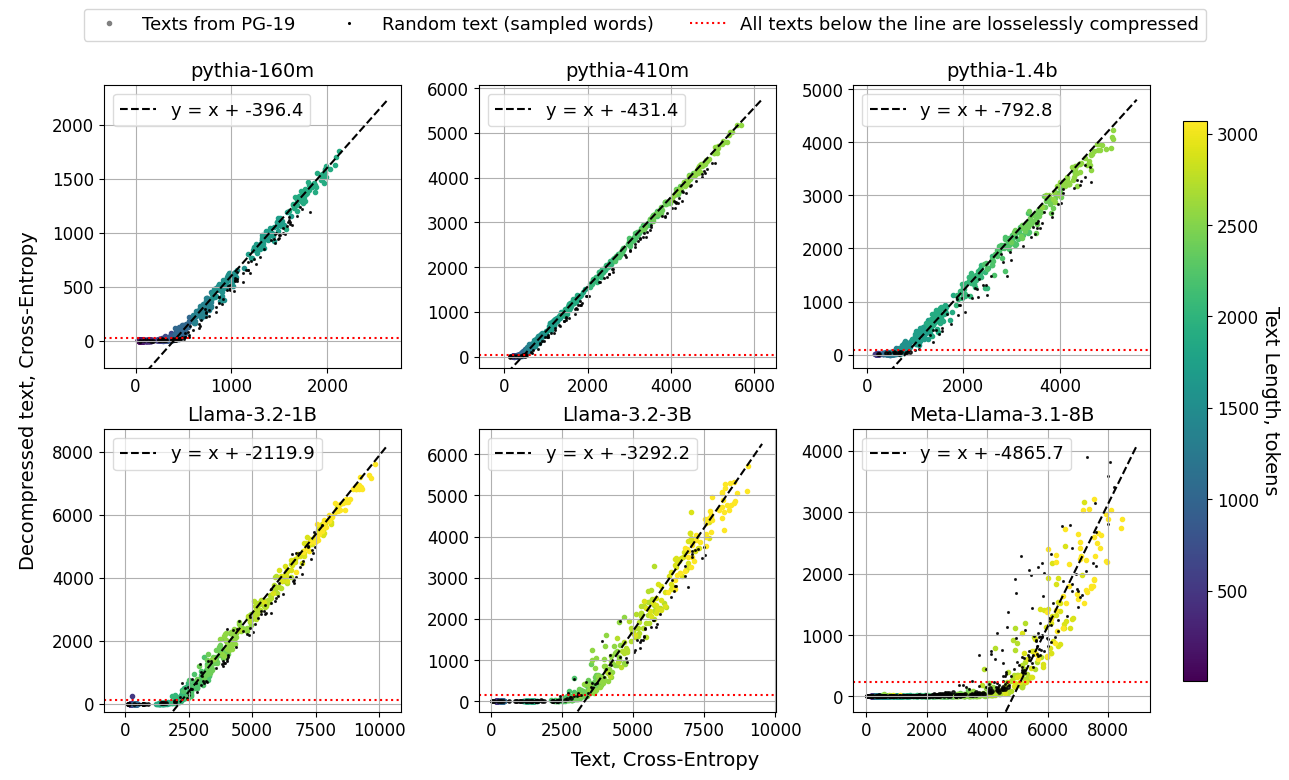

In [67]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from scipy.optimize import curve_fit

pg19_texts_df = data_df[data_df['source'] == 'pg19']
random_texts_df = data_df[data_df['source'] == 'random']


# List of models
models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
          'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']
N_mem_tokens = 1

# Create subplots for each model
n_columns = 3
n_rows = (len(models) + n_columns - 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, 4 * n_rows),sharey=False,sharex=False)

s = 6
acc_thr = 0.99
alpha=0.8

def polynomial(x, a, b):
    return 1.0 * x + b

# Define a global color map for max_lengths
max_lengths = sorted(pg19_texts_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

# Create a continuous colormap object (e.g., viridis)
cmap = plt.cm.viridis
vmin, vmax = min(max_lengths), max(max_lengths)
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

data = []
for idx, model_name in enumerate(models):

    df = pg19_texts_df[pg19_texts_df['model_name'] == model_name]
    if len(df) == 0:
        print(f'skipping {model_name}')
        continue

    # Split data based on best_accuracy threshold
    d_below_thr = df[df['best_accuracy'] < acc_thr]
    d_above_thr = df[df['best_accuracy'] >= acc_thr]

    # Extract data for fitting
    x_data = d_below_thr['original_CE']
    y_data = d_below_thr['best_CE']

    # Use curve_fit to fit the polynomial function to the data
    if len(y_data) > 0:
        params, _ = curve_fit(polynomial, x_data, y_data)
        a, b = params

        # Generate values for the fitted curve
        x_fit = np.linspace(min(x_data) - 500, max(x_data) + 500, 500)
        y_fit = polynomial(x_fit, *params)

    # Define a colormap to assign consistent colors to each unique max_length
    # colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))
    # color_map = {max_length: colors(i) for i, max_length in enumerate(df['max_length'].unique())}

    ax = axes.flat[idx]

    # Plot data points, grouped by max_length
    for max_length in sorted(df['max_length'].unique()):
        subset_below = d_below_thr[d_below_thr['max_length'] == max_length]
        subset_above = d_above_thr[d_above_thr['max_length'] == max_length]

        # Plot points below the accuracy threshold
        if len(subset_below) > 0:
            ax.scatter(
                subset_below['original_CE'],
                subset_below['best_CE'],
                # label=f'length={max_length}',
                s=s * 1.5,
                color=global_color_map[max_length]
            )

        # Plot points above the accuracy threshold
        if len(subset_above) > 0:
            ax.scatter(
                subset_above['original_CE'], 
                subset_above['best_CE'],
                color=global_color_map[max_length],  # Use the same color as for the points below the threshold
                # marker='x', 
                s=s * 1.5,# s=s * 2,
                # label=f'length={max_length}, accuracy>={acc_thr}'
            )

    # Highlight points where shuffled is True
    shuffled_df = random_texts_df[random_texts_df['model_name'] == model_name]
    # take only at max 10 points from random texts per length
    # shuffled_df = shuffled_df.groupby('max_length').apply(lambda x: x.sample(min(25, len(x))), include_groups=False).reset_index(drop=False, level=0)
    if len(shuffled_df) > 0:
        shuffled_df = shuffled_df[shuffled_df['original_CE'] <= max(x_data)]
        d_below_thr_shuffled = shuffled_df[shuffled_df['best_accuracy'] < acc_thr]
        d_above_thr_shuffled = shuffled_df[shuffled_df['best_accuracy'] >= acc_thr]

        if len(d_below_thr_shuffled) > 0:
            ax.scatter(
                d_below_thr_shuffled['original_CE'],
                d_below_thr_shuffled['best_CE'],
                color='black',
                marker='.',
                s=s,
                alpha=alpha,
                # label='Random text'
            )
        if len(d_above_thr_shuffled) > 0:
            ax.scatter(
                d_above_thr_shuffled['original_CE'],
                d_above_thr_shuffled['best_CE'],
                color='black',    
                #marker='.', #marker='x',
                s=s,# s=s * 2,
                alpha=alpha,
                #label=f'random text, accuracy>={acc_thr}'
            )

    # Plot the fitted curve with formula in the legend
    if len(y_data) > 0:
        # formula_label = f'Line: y = {a:.0f}x + {b:.1f}'
        formula_label = f'y = x + {b:.1f}'
        ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=1.5, label=formula_label)

    # Find the value of best_loss corresponding to the accuracy threshold
    best_loss_thr = d_above_thr['best_CE'].max()

    # Add a horizontal line for the best_loss threshold
    ax.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=1.5,)# label=f'loss threshold for accuracy >= {acc_thr}')

    # Labels, legend, and grid for each subplot
    # ax.set_xlabel('Text, Entropy')
    ax.set_title(f"{model_name.split('/')[-1]}")
    ax.grid()

    # ax.plot([], [], color='black', marker='x', s=s * 2, alpha=alpha, )

    ax.legend(loc='upper left', frameon=True, fancybox=True, framealpha=0.7)

    # if idx == 0:
        # ax.legend(loc='upper left', frameon=True, fancybox=True, framealpha=0.7)
    
    ax.set_ylim(-250, None)

# Set common ylabel for all subplots
# axes[0,0].set_ylabel('Text loss with compressed hidden * length')

# Remove any empty subplots if there are fewer models than subplots
for idx in range(len(models), n_rows * n_columns):
    fig.delaxes(axes.flat[idx])

# Custom legend handle
legend_elements = [
    Line2D([0], [0], color='grey', linestyle='None', marker='o', markersize=np.sqrt(s*1.5), label='Texts from PG-19'),
    Line2D([0], [0], color='black', linestyle='None', marker='.', markersize=np.sqrt(s), label='Random text (sampled words)'),
    Line2D([0], [0], color='red', lw=1.5, linestyle=':',  label='All texts below the line are losselessly compressed'),
]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='upper center', ncol=4, )

# Set common ylabel for all subplots
fig.text(0.04, 0.5, 'Decompressed text, Cross-Entropy', va='center', rotation='vertical')
fig.text(0.5, 0.05, 'Text, Cross-Entropy', va='center', rotation='horizontal')


fig.subplots_adjust(right=0.85)

# 4) Create a new axes for the colorbar outside the main figure area
#    (x-position, y-position, width, height).
cax = fig.add_axes([1.01, 0.15, 0.02, 0.7])

# 5) Create a ScalarMappable to link the colormap and normalization
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # For older Matplotlib compatibility

# 6) Draw the colorbar in the new axes
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Text Length, tokens", rotation=270, labelpad=15)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95], w_pad=.00, h_pad=0.5)  # Adjust layout to accommodate legends and labels properly


plt.savefig("notebooks/imgs/entropy_vs_compressed_entropy.pdf", format='pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_1540434/3815498564.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))
/tmp/ipykernel_1540434/3815498564.py:61: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(polynomial, x_data, y_data)
/tmp/ipykernel_1540434/3815498564.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 1, 0.95], w_pad=.00, h_pad=0.5)  # Adjust layout to accommodate legends and labels properly


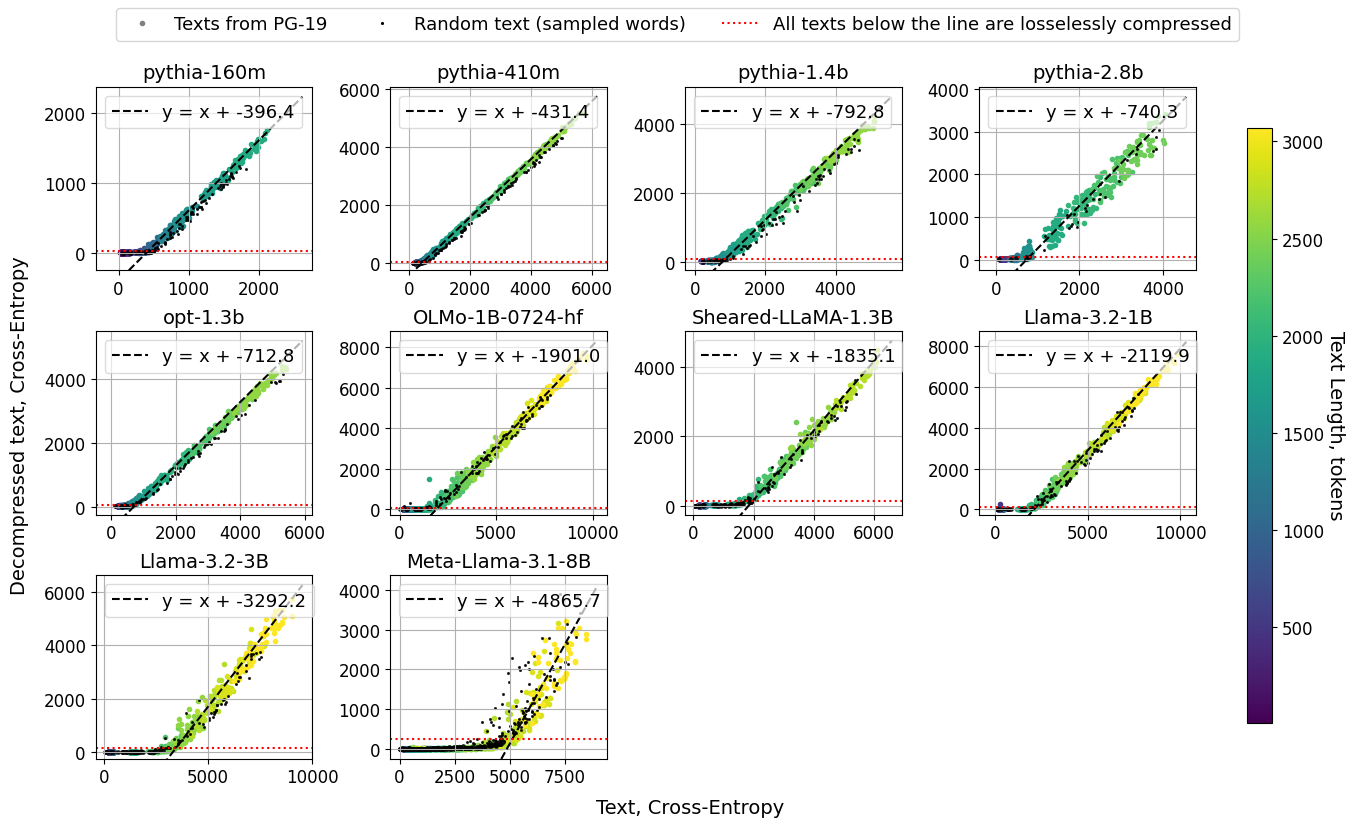

In [46]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from scipy.optimize import curve_fit

pg19_texts_df = data_df[data_df['source'] == 'pg19']
random_texts_df = data_df[data_df['source'] == 'random']


# List of models
models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
               'EleutherAI/pythia-2.8b', #'EleutherAI/pythia-6.9b',
               'facebook/opt-1.3b', 'allenai/OLMo-1B-0724-hf',
               'princeton-nlp/Sheared-LLaMA-1.3B',
               'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B',
                ]
            #    'Qwen/Qwen2.5-0.5B', 'Qwen/Qwen2.5-1.5B','Qwen/Qwen2.5-3B',]
N_mem_tokens = 1

# Create subplots for each model
n_columns = 4
n_rows = (len(models) + n_columns - 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(15*0.85, 10*0.85),sharey=False,sharex=False)

s = 6
acc_thr = 0.99
alpha=0.8

def polynomial(x, a, b):
    return 1.0 * x + b

# Define a global color map for max_lengths
max_lengths = sorted(pg19_texts_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

# Create a continuous colormap object (e.g., viridis)
cmap = plt.cm.viridis
vmin, vmax = min(max_lengths), max(max_lengths)
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

data = []
for idx, model_name in enumerate(models):

    df = pg19_texts_df[pg19_texts_df['model_name'] == model_name]
    if len(df) == 0:
        print(f'skipping {model_name}')
        continue

    # Split data based on best_accuracy threshold
    d_below_thr = df[df['best_accuracy'] < acc_thr]
    d_above_thr = df[df['best_accuracy'] >= acc_thr]

    # Extract data for fitting
    x_data = d_below_thr['original_CE']
    y_data = d_below_thr['best_CE']

    # Use curve_fit to fit the polynomial function to the data
    if len(y_data) > 0:
        params, _ = curve_fit(polynomial, x_data, y_data)
        a, b = params

        # Generate values for the fitted curve
        x_fit = np.linspace(min(x_data) - 500, max(x_data) + 500, 500)
        y_fit = polynomial(x_fit, *params)

    # Define a colormap to assign consistent colors to each unique max_length
    # colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))
    # color_map = {max_length: colors(i) for i, max_length in enumerate(df['max_length'].unique())}

    ax = axes.flat[idx]

    # Plot data points, grouped by max_length
    for max_length in sorted(df['max_length'].unique()):
        subset_below = d_below_thr[d_below_thr['max_length'] == max_length]
        subset_above = d_above_thr[d_above_thr['max_length'] == max_length]

        # Plot points below the accuracy threshold
        if len(subset_below) > 0:
            ax.scatter(
                subset_below['original_CE'],
                subset_below['best_CE'],
                # label=f'length={max_length}',
                s=s * 1.5,
                color=global_color_map[max_length]
            )

        # Plot points above the accuracy threshold
        if len(subset_above) > 0:
            ax.scatter(
                subset_above['original_CE'], 
                subset_above['best_CE'],
                color=global_color_map[max_length],  # Use the same color as for the points below the threshold
                # marker='x', 
                s=s * 1.5,# s=s * 2,
                # label=f'length={max_length}, accuracy>={acc_thr}'
            )

    # Highlight points where shuffled is True
    shuffled_df = random_texts_df[random_texts_df['model_name'] == model_name]
    # take only at max 10 points from random texts per length
    # shuffled_df = shuffled_df.groupby('max_length').apply(lambda x: x.sample(min(25, len(x))), include_groups=False).reset_index(drop=False, level=0)
    if len(shuffled_df) > 0:
        shuffled_df = shuffled_df[shuffled_df['original_CE'] <= max(x_data)]
        d_below_thr_shuffled = shuffled_df[shuffled_df['best_accuracy'] < acc_thr]
        d_above_thr_shuffled = shuffled_df[shuffled_df['best_accuracy'] >= acc_thr]

        if len(d_below_thr_shuffled) > 0:
            ax.scatter(
                d_below_thr_shuffled['original_CE'],
                d_below_thr_shuffled['best_CE'],
                color='black',
                marker='.',
                s=s,
                alpha=alpha,
                # label='Random text'
            )
        if len(d_above_thr_shuffled) > 0:
            ax.scatter(
                d_above_thr_shuffled['original_CE'],
                d_above_thr_shuffled['best_CE'],
                color='black',    
                #marker='.', #marker='x',
                s=s,# s=s * 2,
                alpha=alpha,
                #label=f'random text, accuracy>={acc_thr}'
            )

    # Plot the fitted curve with formula in the legend
    if len(y_data) > 0:
        # formula_label = f'Line: y = {a:.0f}x + {b:.1f}'
        formula_label = f'y = x + {b:.1f}'
        ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=1.5, label=formula_label)

    # Find the value of best_loss corresponding to the accuracy threshold
    best_loss_thr = d_above_thr['best_CE'].max()

    # Add a horizontal line for the best_loss threshold
    ax.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=1.5,)# label=f'loss threshold for accuracy >= {acc_thr}')

    # Labels, legend, and grid for each subplot
    # ax.set_xlabel('Text, Entropy')
    ax.set_title(f'{model_name.split("/")[-1]}')
    ax.grid()

    # ax.plot([], [], color='black', marker='x', s=s * 2, alpha=alpha, )

    ax.legend(loc='upper left', frameon=True, fancybox=True, framealpha=0.7)

    # if idx == 0:
        # ax.legend(loc='upper left', frameon=True, fancybox=True, framealpha=0.7)
    
    ax.set_ylim(-250, None)

# Set common ylabel for all subplots
# axes[0,0].set_ylabel('Text loss with compressed hidden * length')

# Remove any empty subplots if there are fewer models than subplots
for idx in range(len(models), n_rows * n_columns):
    fig.delaxes(axes.flat[idx])

# Custom legend handle
legend_elements = [
    Line2D([0], [0], color='grey', linestyle='None', marker='o', markersize=np.sqrt(s*1.5), label='Texts from PG-19'),
    Line2D([0], [0], color='black', linestyle='None', marker='.', markersize=np.sqrt(s), label='Random text (sampled words)'),
    Line2D([0], [0], color='red', lw=1.5, linestyle=':',  label='All texts below the line are losselessly compressed'),
]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='upper center', ncol=4, )

# Set common ylabel for all subplots
fig.text(0.04, 0.5, 'Decompressed text, Cross-Entropy', va='center', rotation='vertical')
fig.text(0.5, 0.05, 'Text, Cross-Entropy', va='center', rotation='horizontal')


fig.subplots_adjust(right=0.85)

# 4) Create a new axes for the colorbar outside the main figure area
#    (x-position, y-position, width, height).
cax = fig.add_axes([1.01, 0.15, 0.02, 0.7])

# 5) Create a ScalarMappable to link the colormap and normalization
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # For older Matplotlib compatibility

# 6) Draw the colorbar in the new axes
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Text Length, tokens", rotation=270, labelpad=15)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95], w_pad=.00, h_pad=0.5)  # Adjust layout to accommodate legends and labels properly


plt.savefig("notebooks/imgs/entropy_vs_compressed_entropy_all_models.pdf", format='pdf', bbox_inches='tight')
plt.show()